In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'
#os.environ['QT_QWS_FONTDIR']='/home/user/lib/fonts-qt/'
import pandas as pd
import sys
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, faces
from ete3 import NCBITaxa

def mard(df, c1, c2):
    a = abs(df[c1]-df[c2])/(df[c1]+df[c2])
    return a.sum()/a.count()

In [3]:
ncbi = NCBITaxa()

In [4]:
def taxa_layout(node):
    nameFace = faces.TextFace(node.name, fsize=6)
    faces.add_face_to_node(nameFace, node, column=0)
    # We can also create faces on the fly
    rankFace = faces.TextFace(node.rank, fsize=10)
    faces.add_face_to_node(rankFace, node, column=0)
    
    countFace = faces.TextFace(node.count, fsize=14, fgcolor='red')
    faces.add_face_to_node(countFace, node, column=0)
        
    # Note that this faces is added in "aligned" mode
    descFace = faces.TextFace(node.sci_name, fsize=12)
    descFace.margin_top = 10
    descFace.margin_bottom = 10
    descFace.border.margin = 1
    faces.add_face_to_node(descFace, node, column=0, aligned=True)

In [5]:
vibrio='/mnt/scratch1/hirak/meta_genome/downloads/vibrio/'
vibrio_all = '/mnt/scratch1/hirak/meta_genome/downloads/vibrio_all/'
#results_dir = '/mnt/scratch1/hirak/meta_genome/downloads/result/leaveOneOut/'
tf = vibrio+"taxonomy/nodes.dmp"
ref = vibrio+"seqid2taxid.map"
taxa = []
id2rank = {}
with open(tf) as f:
    for line in f:
        toks = line.rstrip("\t|\n").split("\t|\t")
        taxa += [[int(toks[0]), int(toks[1]), toks[2]]]
        id2rank[int(toks[0])] = toks[2]
taxa_df = pd.DataFrame.from_records(taxa)
taxa_df.columns = ["taxaId", "pid", "rank"]
with open(ref) as f:
    refId2TaxId = pd.read_csv(f, header=None, sep="\t", names=["refName", "refId"])

In [6]:
def draw_tree(kraken_out, is_filtered=False, filtering_threshold=0):
    krk = pd.read_csv(kraken_out, sep='\t', header=None)
    if is_filtered:
        krk.columns = ['cu', 'rid', 'tid', 'len', 'perc', 'kmers']
    else:
        krk.columns = ['cu', 'rid', 'tid', 'len', 'kmers']
    krk_merged = pd.merge(krk, taxa_df, how='left', left_on='tid', right_on='taxaId')
    print('# of unclassified reads: {}'.format(len(krk_merged[krk_merged['tid'] == 0])))
    a=krk_merged[krk_merged['tid'] != 0][['tid', 'cu']].groupby('tid').count().reset_index()
    a = a[a['cu'] >= filtering_threshold]
    tree = ncbi.get_topology(list(a.tid), intermediate_nodes=True)
    for n in tree.traverse():
        f = a[a['tid'] == n.taxid]
        if f.empty:
            n.add_feature(pr_name='count',pr_value=0)
        else:
            n.add_feature(pr_name='count',pr_value=int(f['cu']))
    ts = TreeStyle()
    #ts.show_leaf_name = False
    #ts.mode = "c"
    ts.layout_fn = taxa_layout
    return tree.render('%%inline', tree_style=ts)

def draw_report_tree(kraken_out, filtering_threshold=0):
    krk = pd.read_csv(kraken_out, sep='\t', header=None)
    krk.columns = ['perc', 'count_agg', 'count', 'rank', 'taxaId', 'sci_name']
    
    print('# of unclassified reads: {}'.format(krk[krk['rank'] == 'U']['count']))
    tree = ncbi.get_topology(list(krk[(krk['rank'] != 'U') & (krk['count'] >= filtering_threshold)].taxaId), intermediate_nodes=True)
    for n in tree.traverse():
        f = krk[krk['taxaId'] == n.taxid]
        if f.empty:
            n.add_feature(pr_name='count',pr_value=0)
        else:
            n.add_feature(pr_name='count',pr_value=int(f['count']))
    ts = TreeStyle()
    #ts.show_leaf_name = False
    #ts.mode = "c"
    ts.layout_fn = taxa_layout
    return tree.render('%%inline', tree_style=ts)
def draw_cedar_tree(cedar_out, is_filtered=False, filtering_threshold=0):
    if isinstance(cedar_out, str):
        cedar = pd.read_csv(cedar_out, sep='\t')
    else:
        cedar = cedar_out
    
    cedar.columns = ['taxaId', 'rank', 'count']
    
    #print('# of unclassified reads: {}'.format(cedar[cedar['rank'] == 'U']['count']))
    tree = ncbi.get_topology(list(cedar[(cedar['rank'] != 'U') & (cedar['count'] >= filtering_threshold)].taxaId), intermediate_nodes=False)
    for n in tree.traverse():
        f = cedar[cedar['taxaId'] == n.taxid]
        if f.empty:
            n.add_feature(pr_name='count',pr_value=0)
        else:
            n.add_feature(pr_name='count',pr_value=int(f['count']))
    ts = TreeStyle()
    #ts.show_leaf_name = False
    #ts.mode = "c"
    ts.layout_fn = taxa_layout
    return tree.render('%%inline', tree_style=ts)
def compare(res1, res2, n1='in', n2='ex', is_filtered=False, filtering_threshold=0):
    ced1 = pd.read_csv(res1, sep='\t')
    ced2 = pd.read_csv(res2, sep='\t')
    ced1.columns = [n1+'_taxaId', n1+'_rank', n1+'_count']
    ced2.columns = [n2+'_taxaId', n2+'_rank', n2+'_count']
    ced1 = ced1[ced1[n1+'_count'] > filtering_threshold]
    ced2 = ced2[ced2[n2+'_count'] > filtering_threshold]
    
    merged = pd.merge(ced1, ced2, left_on = n1+'_taxaId', right_on=n2+'_taxaId', how='outer')
    return merged.sort_values(['in_count'], ascending=False).fillna(0)[[n2+'_taxaId', n1+'_count', n2+'_count']]

# SRR1030492

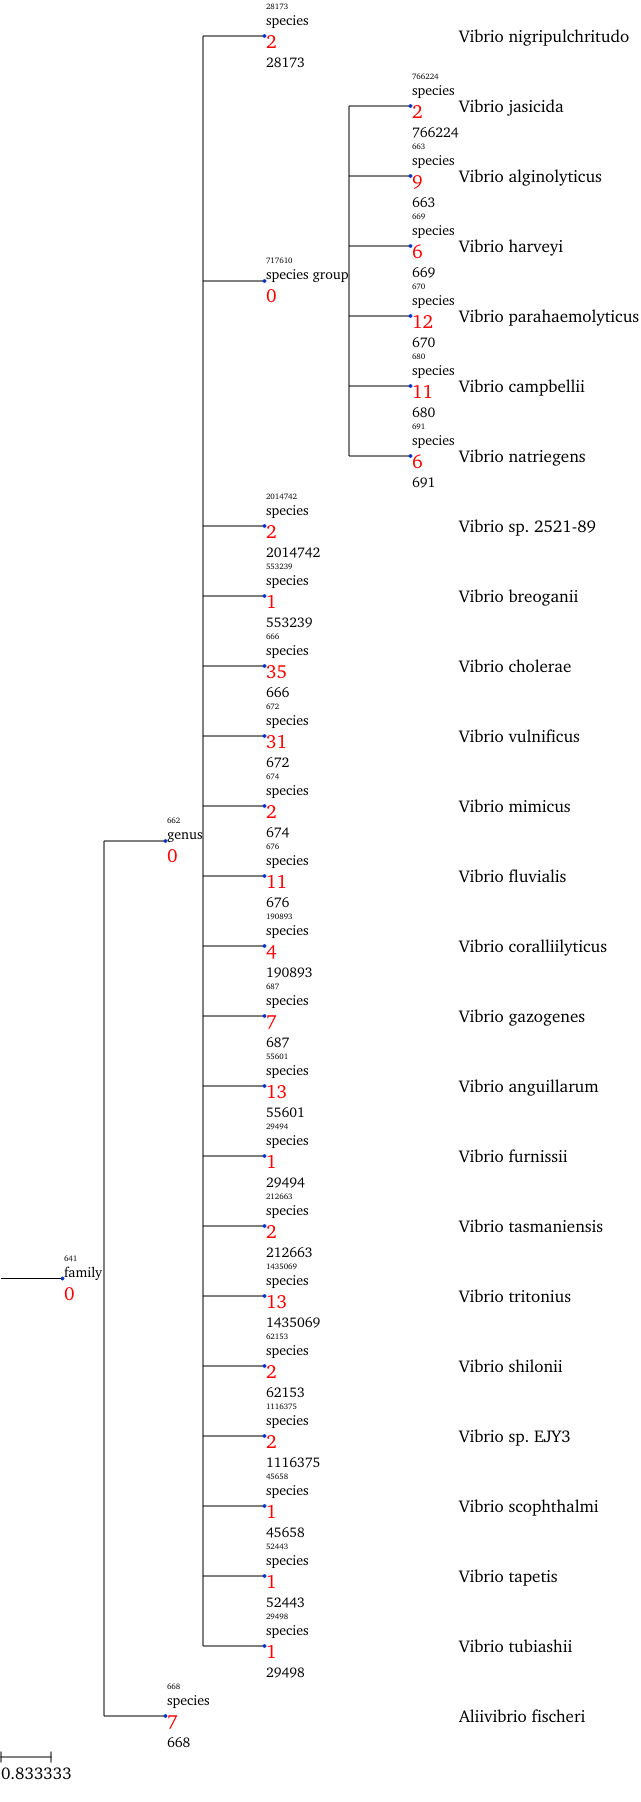

In [7]:
draw_cedar_tree('/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/perfect_uniq_species_SRR1030492.cedar')

# SRR988501

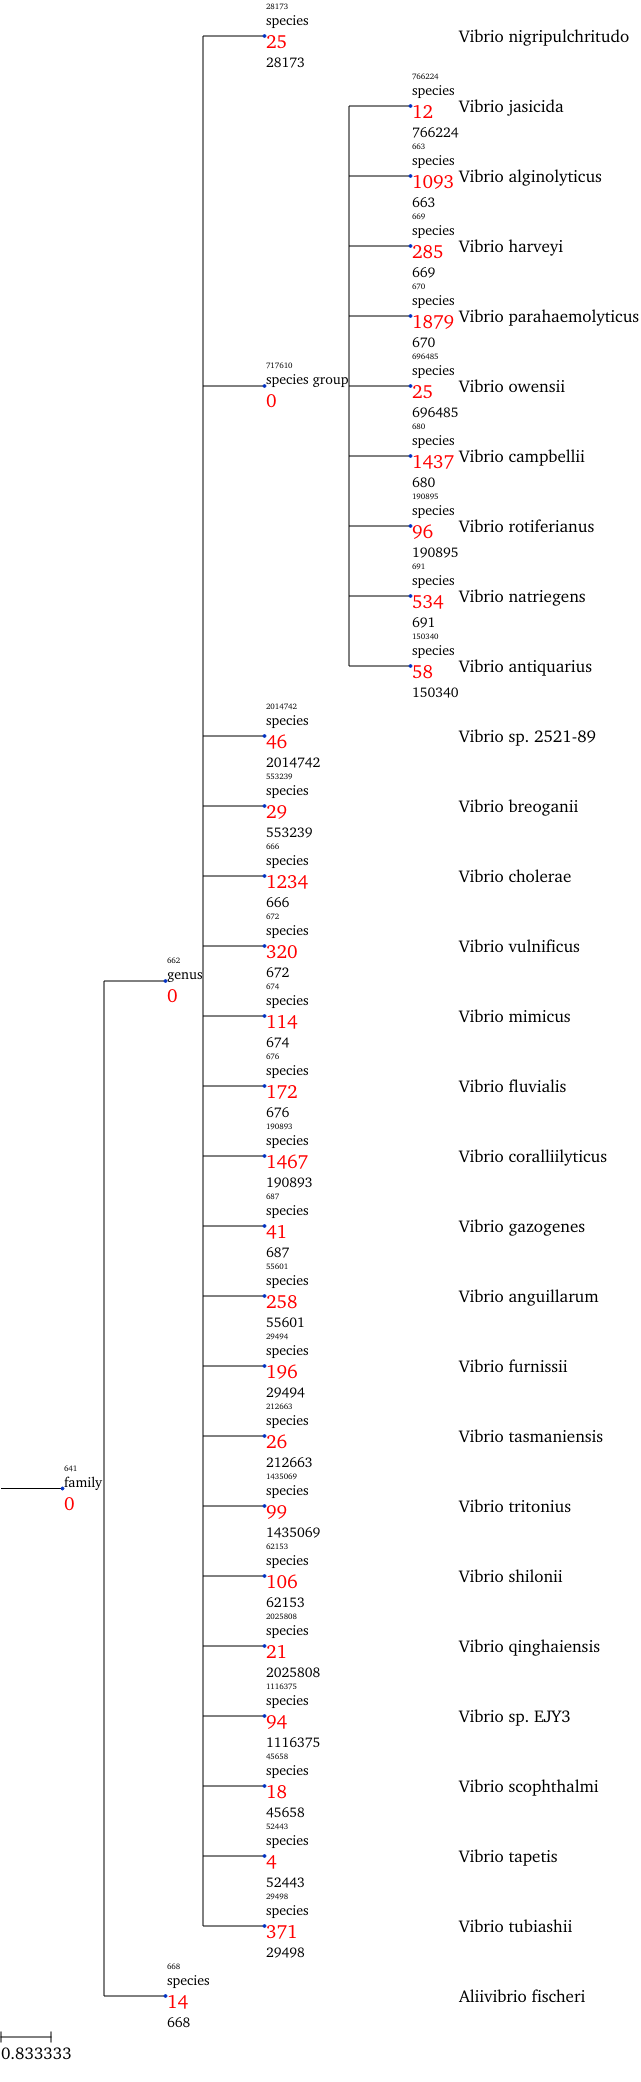

In [8]:
draw_cedar_tree('/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/perfect_uniq_species_SRR988501.cedar')

# SRR976768

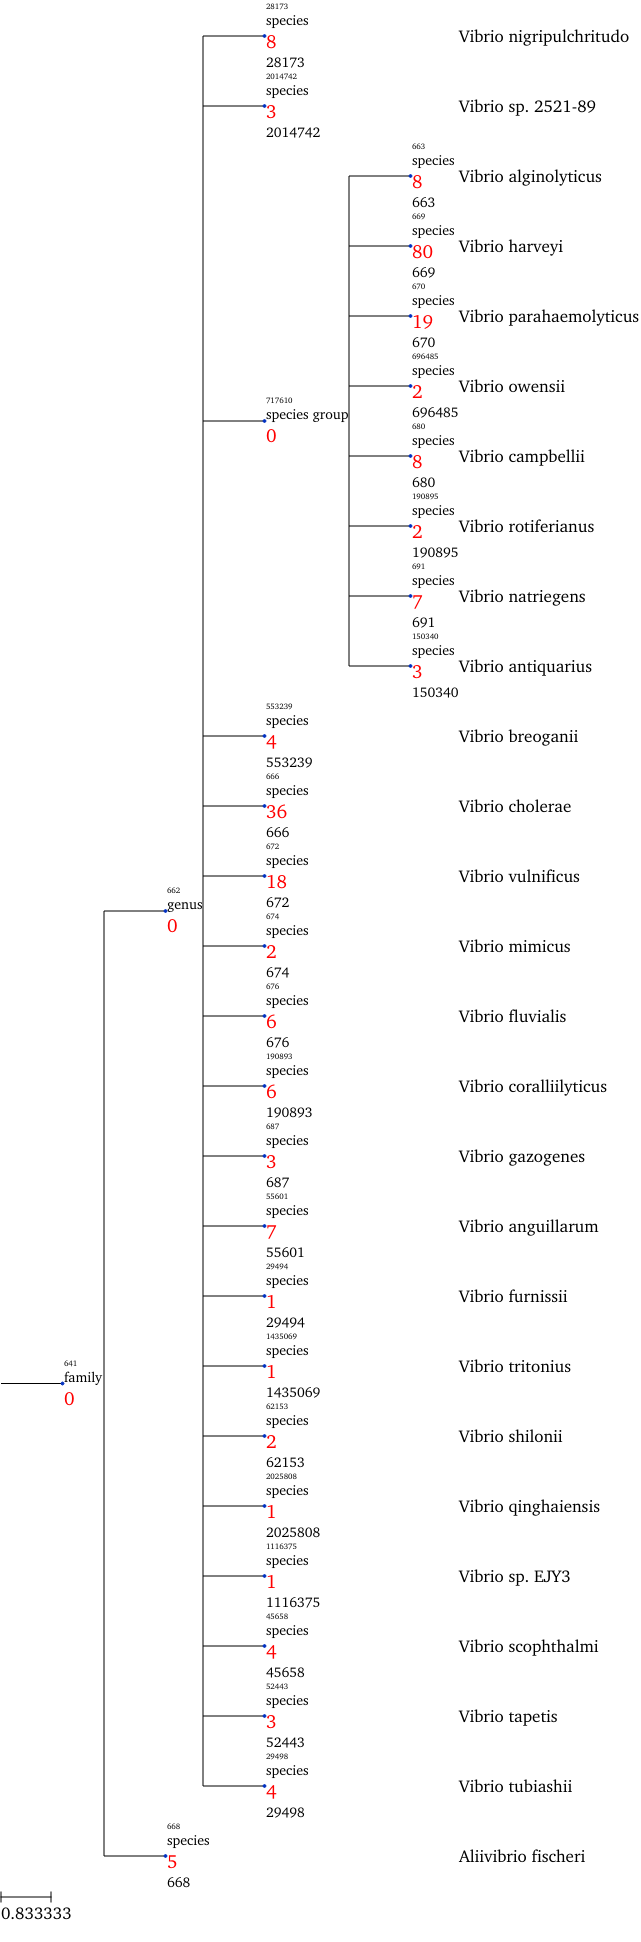

In [9]:
draw_cedar_tree('/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/perfect_uniq_species_SRR976768.cedar')

# Up until here

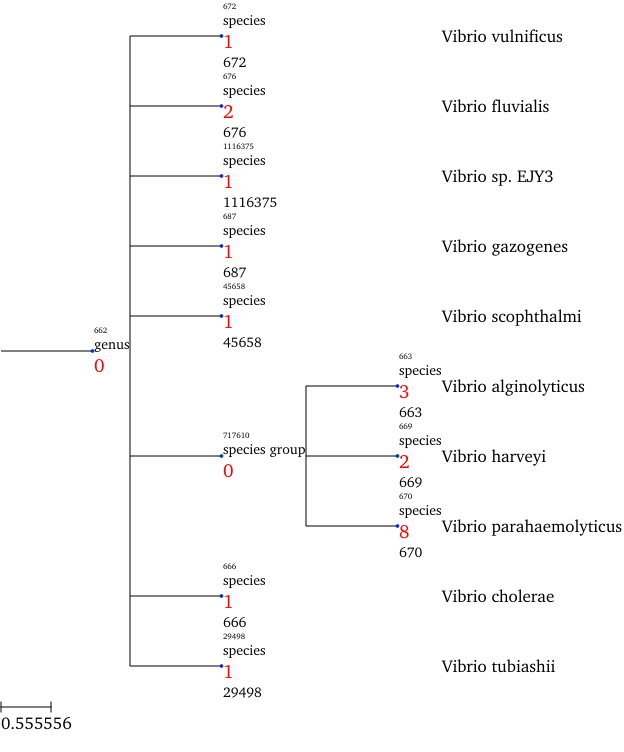

In [10]:
draw_cedar_tree('/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/perfect_uniq_species_SRR770716.cedar')

# of unclassified reads: 0    17476
Name: count, dtype: int64


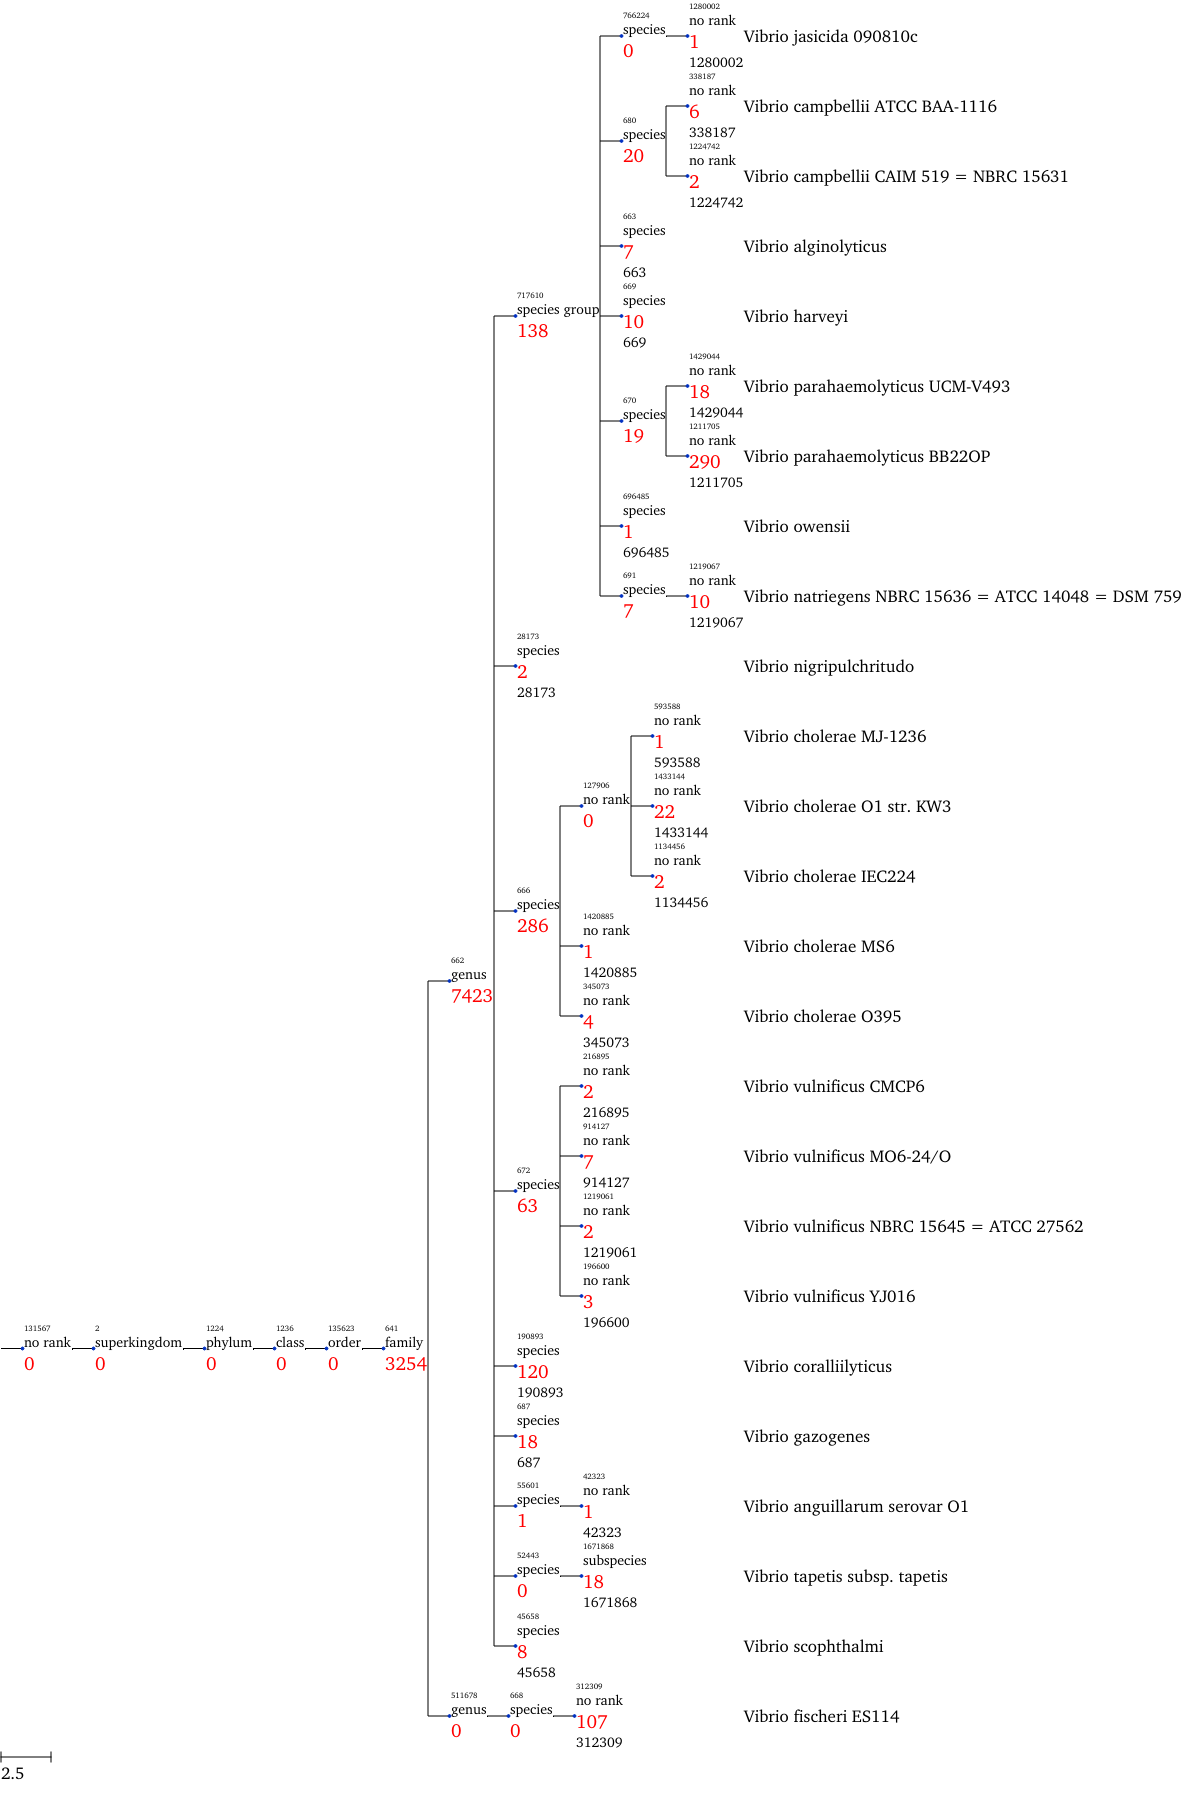

In [23]:
draw_report_tree('/mnt/scratch1/hirak/meta_genome/kraken_output/report_SRR988505.rpt')

# of unclassified reads: 17476


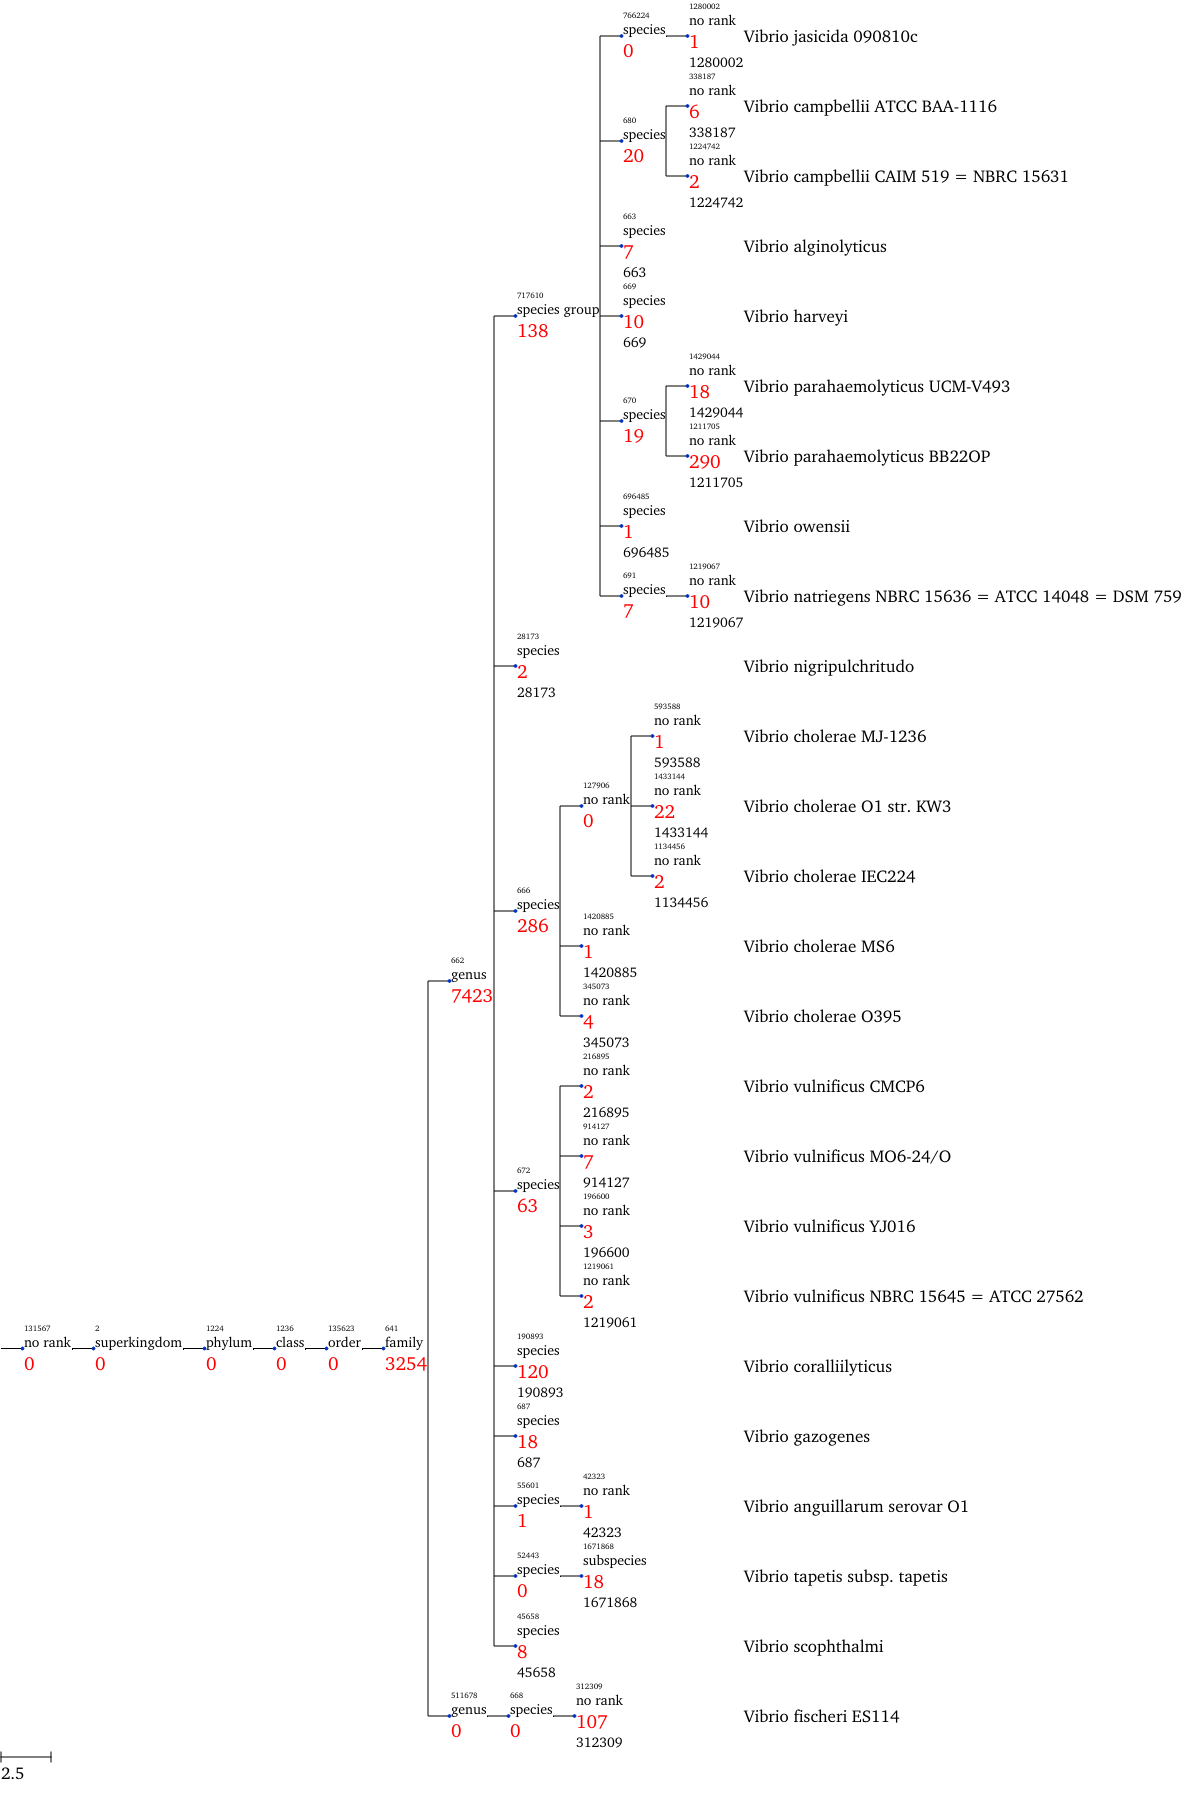

In [26]:
draw_tree('/mnt/scratch1/hirak/meta_genome/kraken_output/SRR988505.krk')

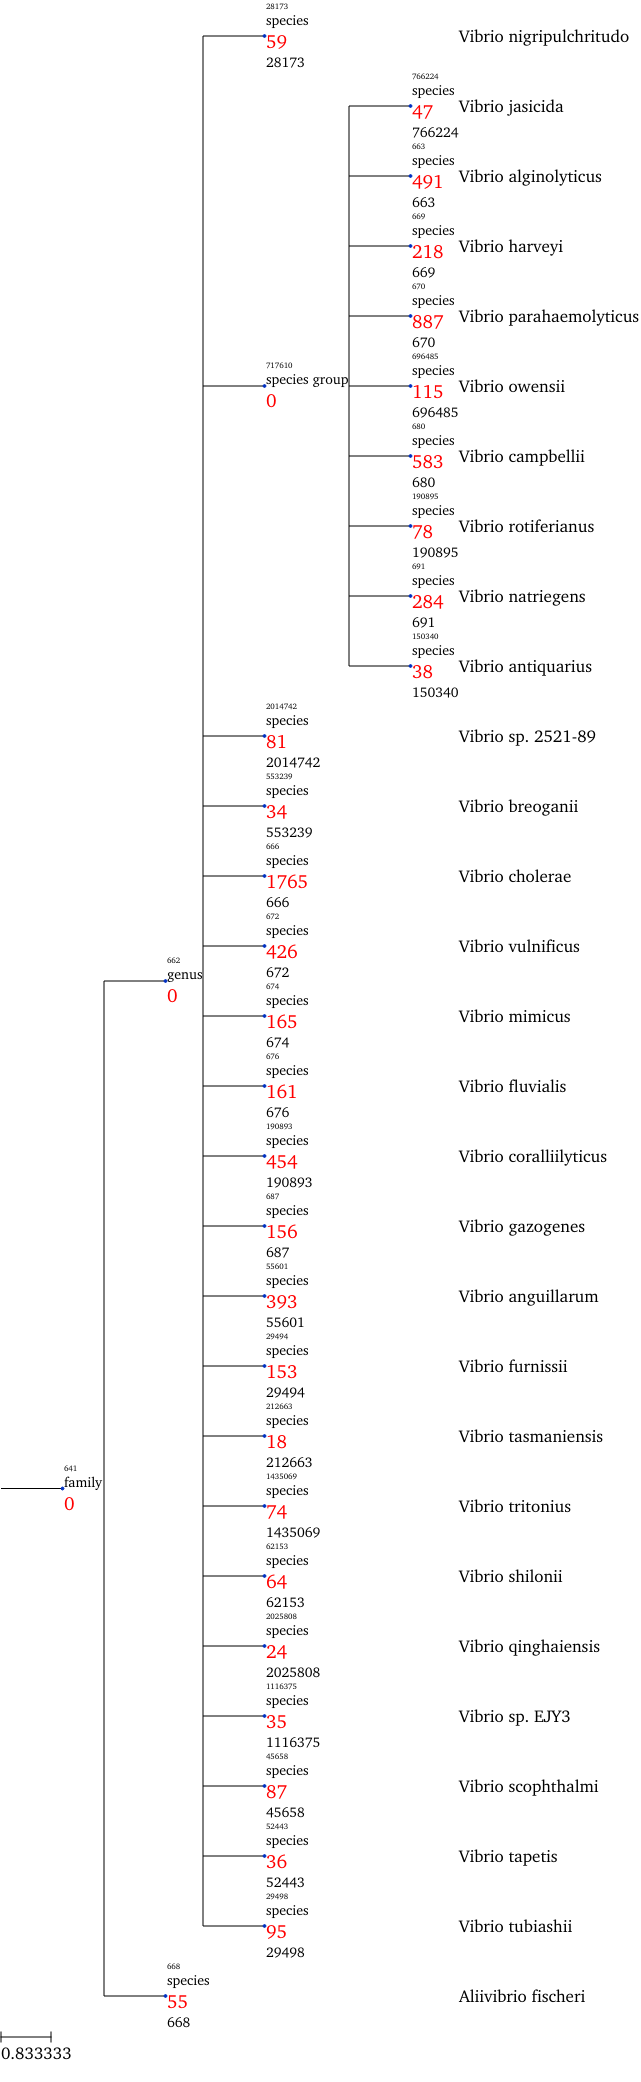

In [27]:
draw_cedar_tree('/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/species_SRR988505.cedar')

In [41]:
compare('/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/uniq_species_SRR1030492.cedar',
       '/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/perfect_uniq_species_SRR1030492.cedar')

,ex_taxaId,in_count,ex_count
28,666.0,471,35.0
25,670.0,183,12.0
12,672.0,146,31.0
7,663.0,132,9.0
16,680.0,121,11.0
18,55601.0,93,13.0
8,669.0,80,6.0
10,676.0,48,11.0
21,691.0,47,6.0
23,668.0,46,7.0


In [54]:
dataset = 'SRR988505'
n0 = 'tot'
n1 = 'uniq'
n2 = 'perf'
tot = '/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/species_{}.cedar'.format(dataset)
uniq = '/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/uniq_species_{}.cedar'.format(dataset)
perf = '/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/perfect_uniq_species_{}.cedar'.format(dataset)
covf = '/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/uniq_species_{}.cedar.coverage'.format(dataset)
ced0 = pd.read_csv(tot, sep='\t')
ced1 = pd.read_csv(uniq, sep='\t')
ced2 = pd.read_csv(perf, sep='\t')
cov = pd.read_csv(covf, sep='\t', header=None)
ced0.columns = [n0+'_taxaId', n0+'_rank', n0+'_count']
ced1.columns = [n1+'_taxaId', n1+'_rank', n1+'_count']
ced2.columns = [n2+'_taxaId', n2+'_rank', n2+'_count']
cov.columns = ['taxaId', 'count']
#ced1 = ced1[ced1[n1+'_count'] > filtering_threshold]
#ced2 = ced2[ced2[n2+'_count'] > filtering_threshold]

merged0 = pd.merge(ced0, ced1, left_on = n0+'_taxaId', right_on=n1+'_taxaId', how='outer')
merged = pd.merge(merged0, ced2, left_on = n0+'_taxaId', right_on=n2+'_taxaId', how='outer')
cov_merged = pd.merge(merged, cov, left_on = n0+'_taxaId', right_on='taxaId', how='left')
cov_merged['cov'] = cov_merged['count']/cov_merged['uniq_count']
cov_merged.sort_values([n1+'_count'], ascending=False).fillna(0)[[n0+'_taxaId', n2+'_count', n1+'_count', n0+'_count']]#, 'cov']]

,tot_taxaId,perf_count,uniq_count,tot_count
28,666,75.0,782,1765.0900
25,670,72.0,610,887.8800
16,680,55.0,469,583.6030
7,663,32.0,379,491.3170
12,672,7.0,325,426.0850
18,55601,17.0,297,393.8190
19,190893,38.0,221,454.7540
21,691,15.0,186,284.1590
8,669,10.0,176,218.9780
4,687,5.0,103,156.7090


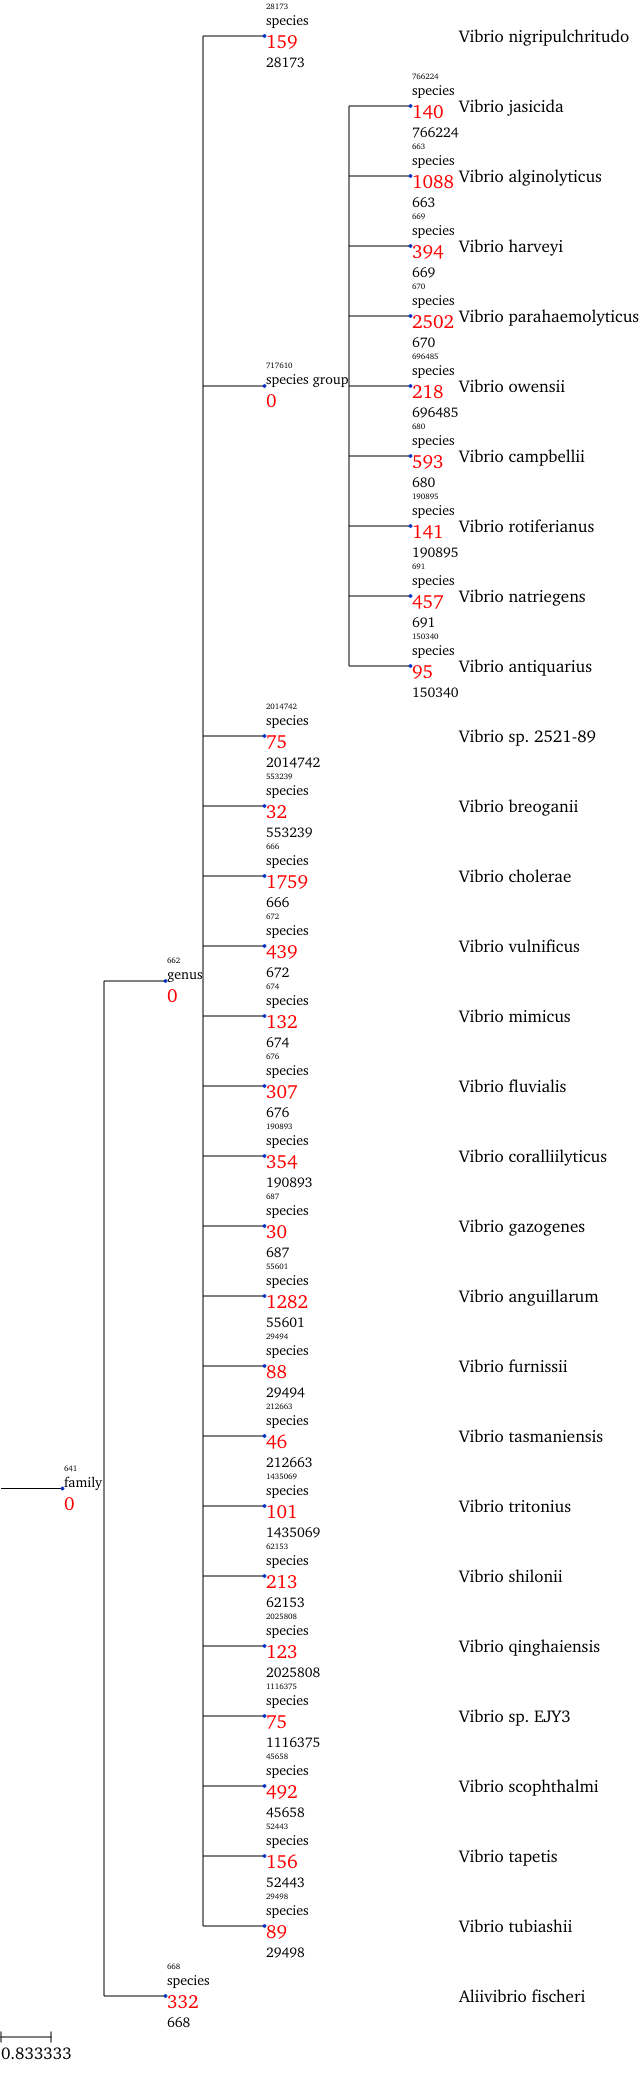

In [61]:
dataset='SRR1313081'
perf = '/mnt/scratch1/hirak/meta_genome/pufferfish/cedar/real_shortReads/perfect_uniq_species_{}.cedar'.format(dataset)
draw_cedar_tree(perf)

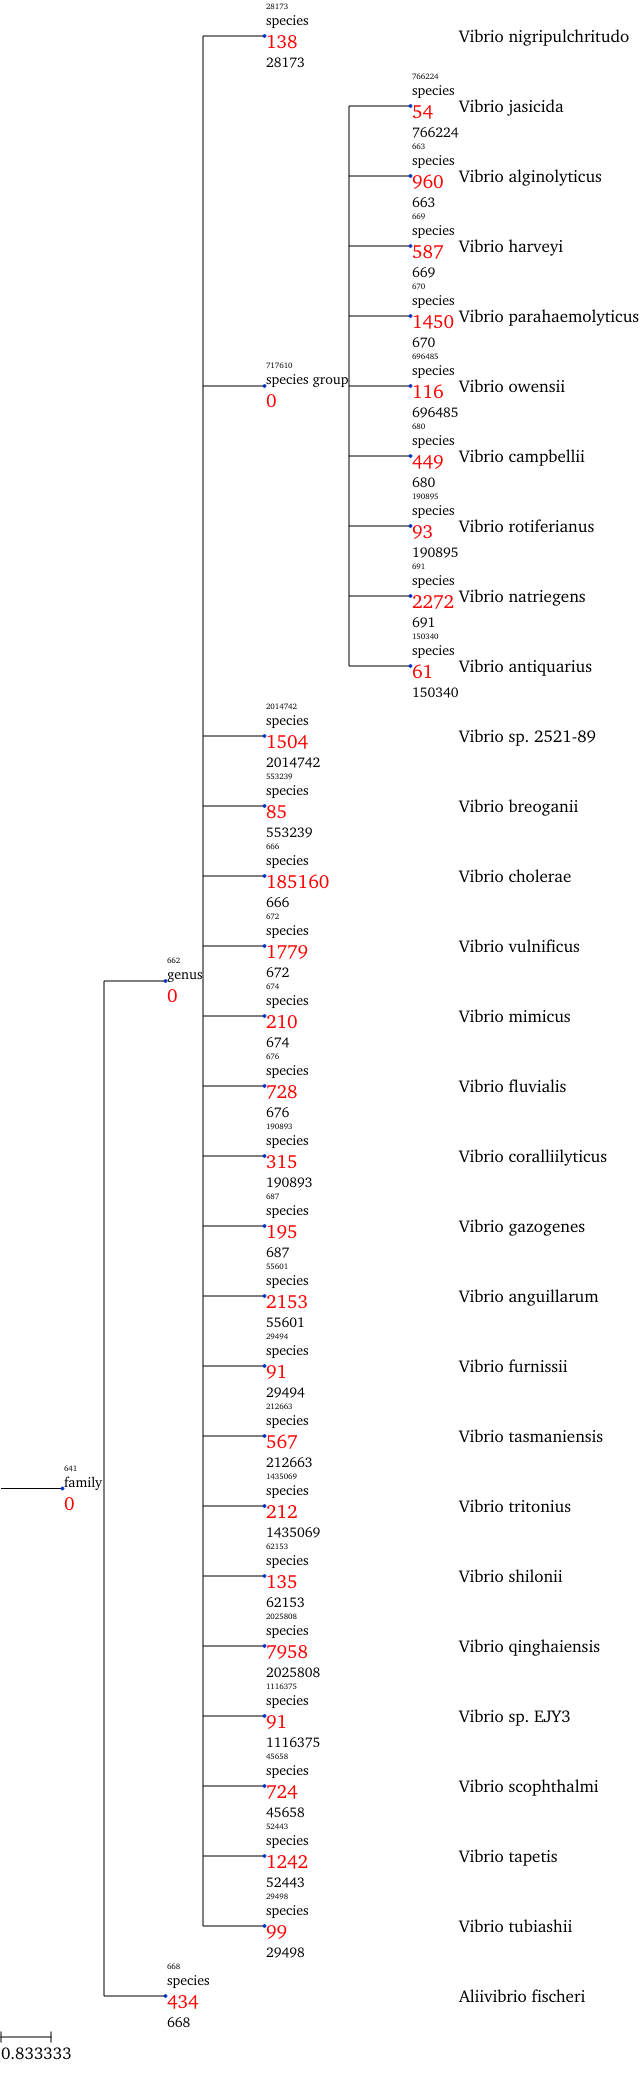

In [37]:
draw_cedar_tree('/mnt/scratch1/hirak/meta_genome/downloads/real_read_res/cedar_out/uniq_species_vibrio.cedar')

# of unclassified reads: 0    31744164
Name: count, dtype: int64


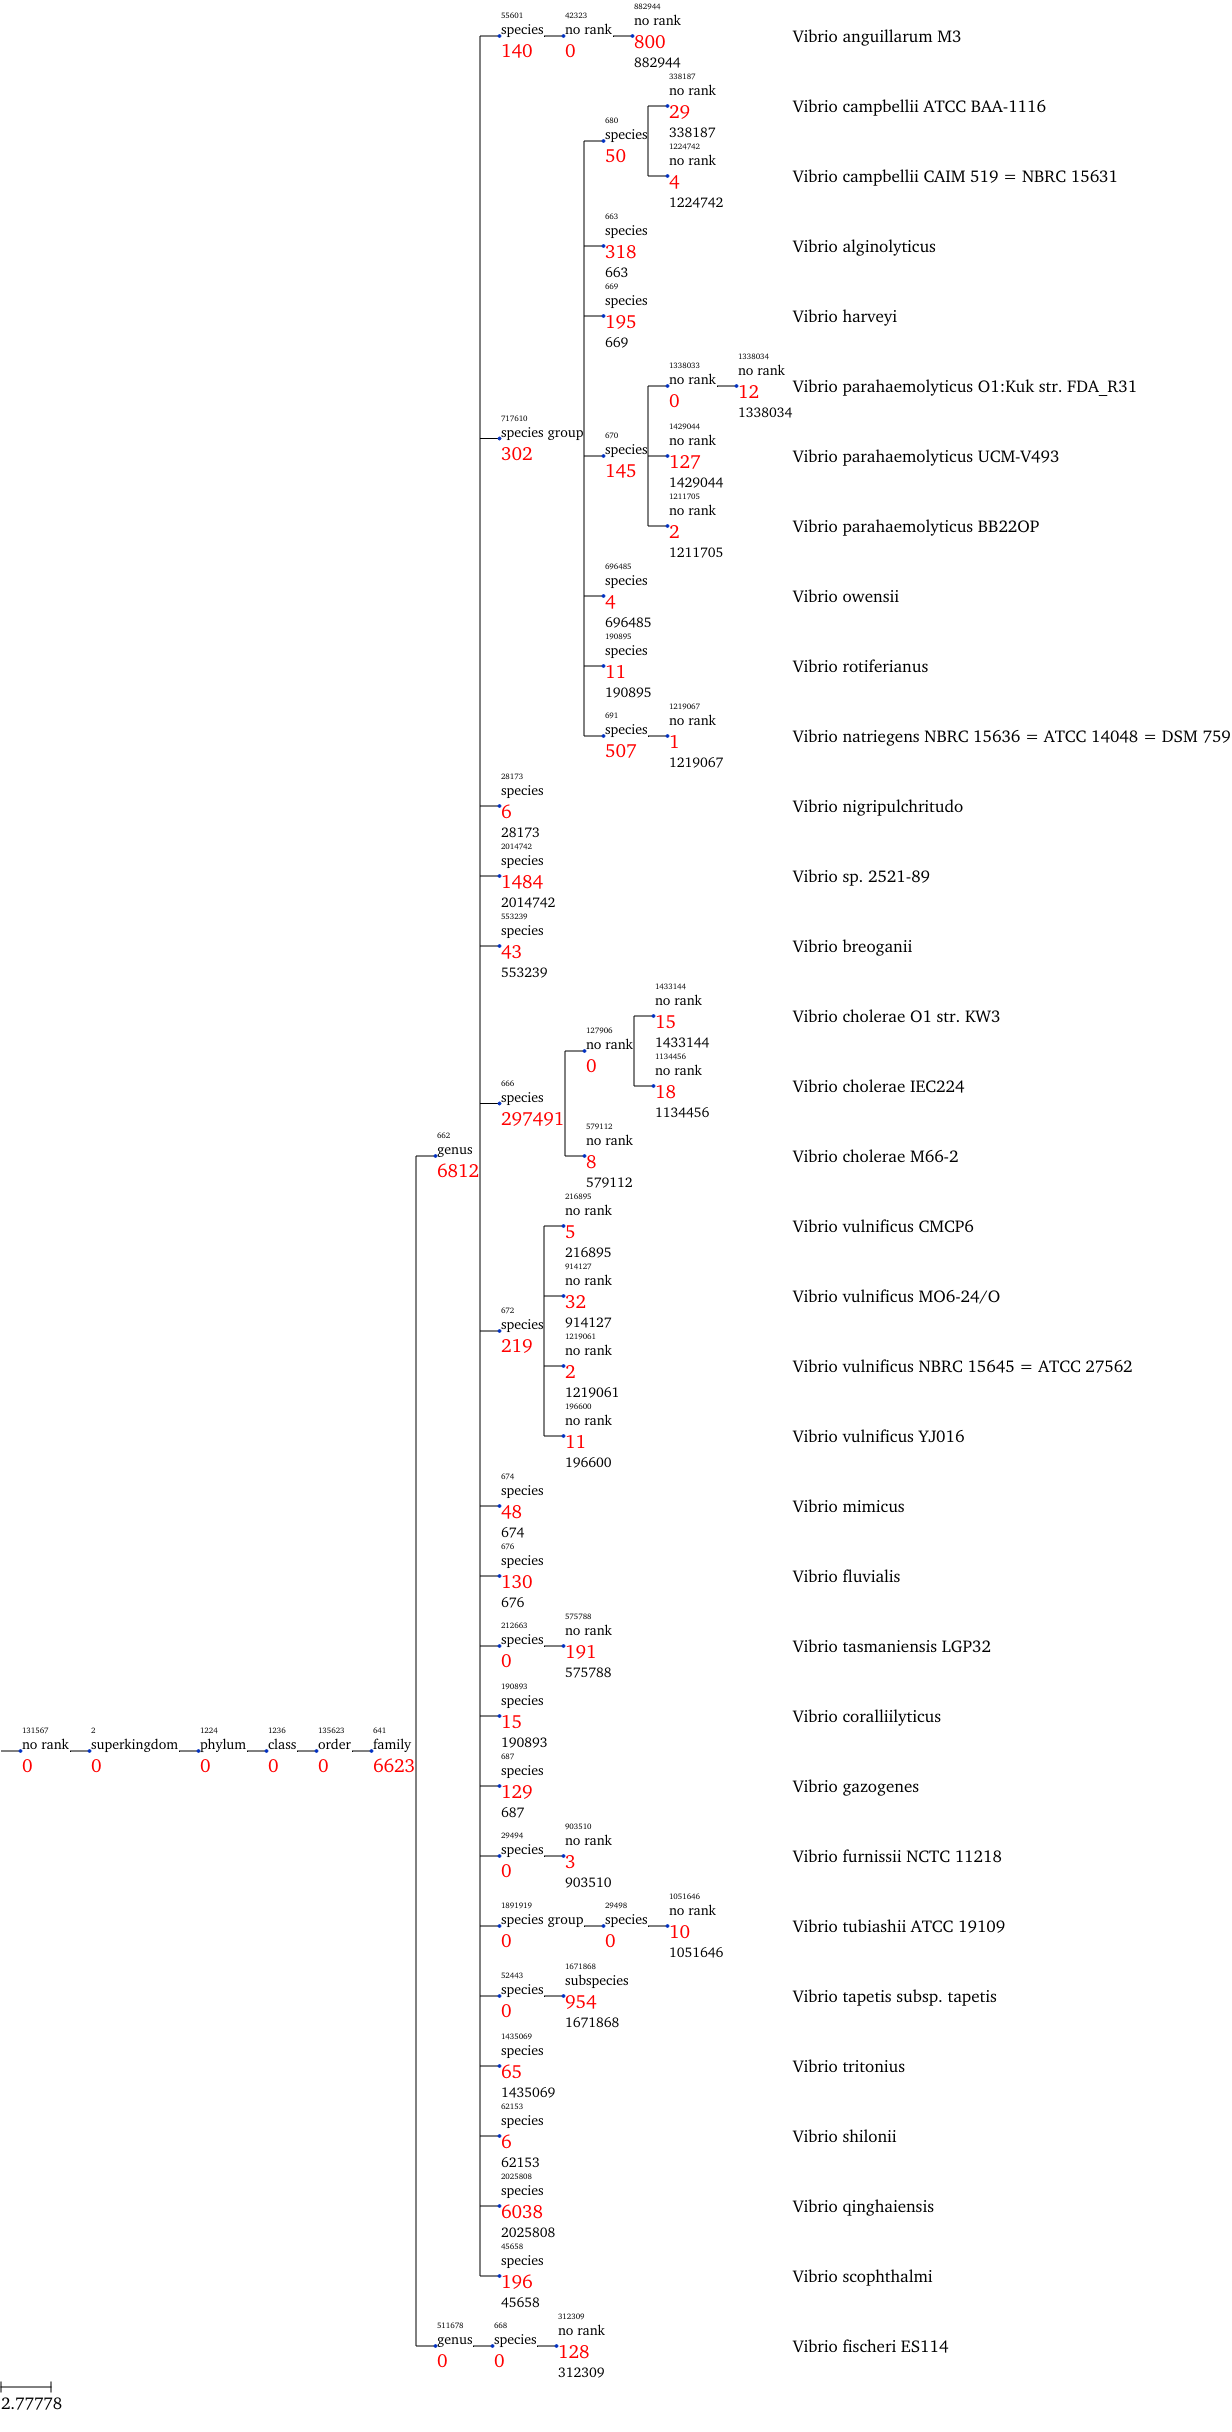

In [39]:
draw_report_tree('/mnt/scratch1/hirak/meta_genome/downloads/real_read_res/kraken_out/report.rpt')